In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import control.optimal as opt
ct.use_fbs_defaults()

In [2]:
def vehicle_update(t, x, u, params):
    # Get the parameters for the model
    a = params.get('refoffset', 1.5)        # offset to vehicle reference point
    b = params.get('wheelbase', 3.)         # vehicle wheelbase
    maxsteer = params.get('maxsteer', 0.5)  # max steering angle (rad)

    # Saturate the steering input
    delta = np.clip(u[1], -maxsteer, maxsteer)
    alpha = np.arctan2(a * np.tan(delta), b)

    # Return the derivative of the state
    return np.array([
        u[0] * np.cos(x[2] + alpha),    # xdot = cos(theta + alpha) v
        u[0] * np.sin(x[2] + alpha),    # ydot = sin(theta + alpha) v
        (u[0] / b) * np.tan(delta)      # thdot = v/l tan(phi)
    ])

def vehicle_output(t, x, u, params):
    return x[0:2]

# Default vehicle parameters (including nominal velocity)
vehicle_params={'refoffset': 1.5, 'wheelbase': 3, 'velocity': 15,
                'maxsteer': 0.5}

# Define the vehicle steering dynamics as an input/output system
vehicle = ct.NonlinearIOSystem(
    vehicle_update, vehicle_output, states=3, name='vehicle',
    inputs=('v', 'delta'), outputs=('x', 'y'), params=vehicle_params)

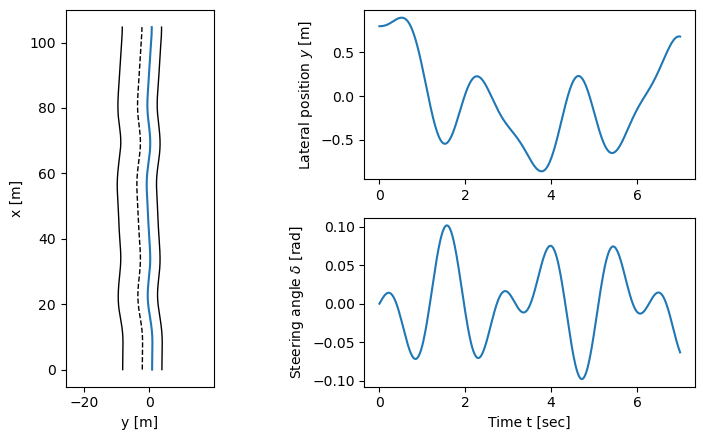

In [3]:
# System parameters
wheelbase = vehicle_params['wheelbase']
v0 = vehicle_params['velocity']

# Control inputs
T_curvy = np.linspace(0, 7, 500)
v_curvy = v0*np.ones(T_curvy.shape)
delta_curvy = 0.1*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.0025*np.sin(T_curvy*np.pi/7)
u_curvy = [v_curvy, delta_curvy]
X0_curvy = [0, 0.8, 0]

# Simulate the system + estimator
t_curvy, y_curvy, x_curvy = ct.input_output_response(
    vehicle, T_curvy, u_curvy, X0_curvy, params=vehicle_params, return_x=True)

# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])

# Plot the resulting trajectory (and some road boundaries)
plt.subplot(1, 4, 2)
plt.plot(y_curvy[1], y_curvy[0])
plt.plot(y_curvy[1] - 9/np.cos(x_curvy[2]), y_curvy[0], 'k-', linewidth=1)
plt.plot(y_curvy[1] - 3/np.cos(x_curvy[2]), y_curvy[0], 'k--', linewidth=1)
plt.plot(y_curvy[1] + 3/np.cos(x_curvy[2]), y_curvy[0], 'k-', linewidth=1)

plt.xlabel('y [m]')
plt.ylabel('x [m]');
plt.axis('Equal')

# Plot the lateral position
plt.subplot(2, 2, 2)
plt.plot(t_curvy, y_curvy[1])
plt.ylabel('Lateral position $y$ [m]')

# Plot the steering angle
plt.subplot(2, 2, 4)
plt.plot(t_curvy, delta_curvy)
plt.ylabel('Steering angle $\\delta$ [rad]')
plt.xlabel('Time t [sec]')
plt.tight_layout()

In [4]:
# Define the lateral dynamics as a subset of the full vehicle steering dynamics
lateral = ct.NonlinearIOSystem(
    lambda t, x, u, params: vehicle_update(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    lambda t, x, u, params: vehicle_output(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    states=2, name='lateral', inputs=('phi'), outputs=('y')
)

# Compute the linearization at velocity v0 = 15 m/sec
lateral_linearized = ct.linearize(lateral, [0, 0], [0], params=vehicle_params)

# Normalize dynamics using state [x1/b, x2] and timescale v0 t / b
b = vehicle_params['wheelbase']
v0 = vehicle_params['velocity']
lateral_transformed = ct.similarity_transform(
    lateral_linearized, [[1/b, 0], [0, 1]], timescale=v0/b)

# Set the output to be the normalized state x1/b
lateral_normalized = lateral_transformed * (1/b)
print("Linearized system dynamics:\n")
print(lateral_normalized)

# Save the system matrices for later use
A = lateral_normalized.A
B = lateral_normalized.B
C = lateral_normalized.C

Linearized system dynamics:

<StateSpace>: sys[1]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[0. 1.]
     [0. 0.]]

B = [[0.16666667]
     [0.33333333]]

C = [[3. 0.]]

D = [[0.]]



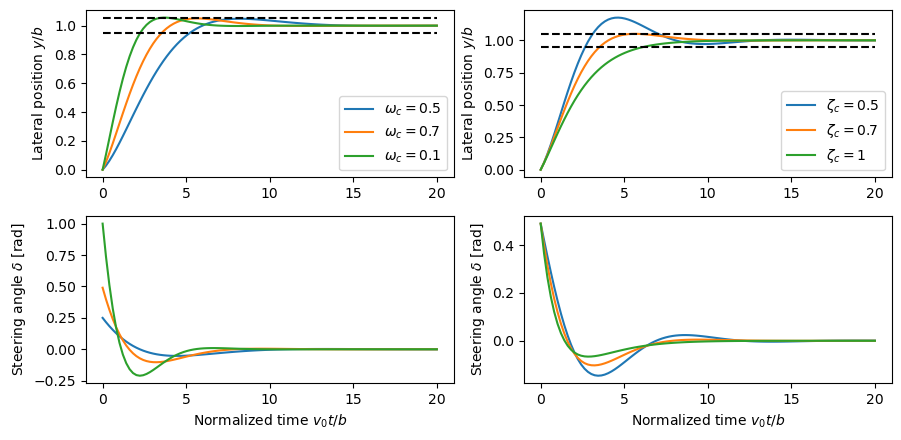

In [5]:
# Utility function to place poles for the normalized vehicle steering system
def normalized_place(wc, zc):
    # Get the dynamics and input matrices, for later use
    A, B = lateral_normalized.A, lateral_normalized.B

    # Compute the eigenvalues from the characteristic polynomial
    eigs = np.roots([1, 2*zc*wc, wc**2])

    # Compute the feedback gain using eigenvalue placement
    K = ct.place_varga(A, B, eigs)

    # Create a new system representing the closed loop response
    clsys = ct.StateSpace(A - B @ K, B, lateral_normalized.C, 0)

    # Compute the feedforward gain based on the zero frequency gain of the closed loop
    kf = np.real(1/clsys(0))

    # Scale the input by the feedforward gain
    clsys *= kf

    # Return gains and closed loop system dynamics
    return K, kf, clsys

# Utility function to plot simulation results for normalized vehicle steering system
def normalized_plot(t, y, u, inpfig, outfig):
    plt.sca(outfig)
    plt.plot(t, y)
    plt.sca(inpfig)
    plt.plot(t, u[0])

# Utility function to label plots of normalized vehicle steering system
def normalized_label(inpfig, outfig):
    plt.sca(inpfig)
    plt.xlabel('Normalized time $v_0 t / b$')
    plt.ylabel('Steering angle $\delta$ [rad]')

    plt.sca(outfig)
    plt.ylabel('Lateral position $y/b$')
    plt.plot([0, 20], [0.95, 0.95], 'k--')
    plt.plot([0, 20], [1.05, 1.05], 'k--')

# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])

# Explore range of values for omega_c, with zeta_c = 0.7
outfig = plt.subplot(2, 2, 1)
inpfig = plt.subplot(2, 2, 3)
zc = 0.7
for wc in [0.5, 0.7, 1]:
    # Place the poles of the system
    K, kf, clsys = normalized_place(wc, zc)

    # Compute the step response
    t, y, x = ct.step_response(clsys, np.linspace(0, 20, 100), return_x=True)

    # Compute the input used to generate the control response
    u = -K @ x + kf * 1

    # Plot the results
    normalized_plot(t, y, u, inpfig, outfig)

# Add labels to the figure
normalized_label(inpfig, outfig)
plt.legend(('$\omega_c = 0.5$', '$\omega_c = 0.7$', '$\omega_c = 0.1$'))

# Explore range of values for zeta_c, with omega_c = 0.07
outfig = plt.subplot(2, 2, 2)
inpfig = plt.subplot(2, 2, 4)
wc = 0.7
for zc in [0.5, 0.7, 1]:
    # Place the poles of the system
    K, kf, clsys = normalized_place(wc, zc)

    # Compute the step response
    t, y, x = ct.step_response(clsys, np.linspace(0, 20, 100), return_x=True)

    # Compute the input used to generate the control response
    u = -K @ x + kf * 1

    # Plot the results
    normalized_plot(t, y, u, inpfig, outfig)

# Add labels to the figure
normalized_label(inpfig, outfig)
plt.legend(('$\zeta_c = 0.5$', '$\zeta_c = 0.7$', '$\zeta_c = 1$'))
plt.tight_layout()

In [6]:
# Find the eigenvalue from the characteristic polynomial
wo = 1          # bandwidth for the observer
zo = 0.7        # damping ratio for the observer
eigs = np.roots([1, 2*zo*wo, wo**2])

# Compute the estimator gain using eigenvalue placement
L = np.transpose(
    ct.place(np.transpose(A), np.transpose(C), eigs))
print("L = ", L)

# Create a linear model of the lateral dynamics driving the estimator
est = ct.StateSpace(A - L @ C, np.block([[B, L]]), np.eye(2), np.zeros((2,2)))

L =  [[0.46666667]
 [0.33333333]]


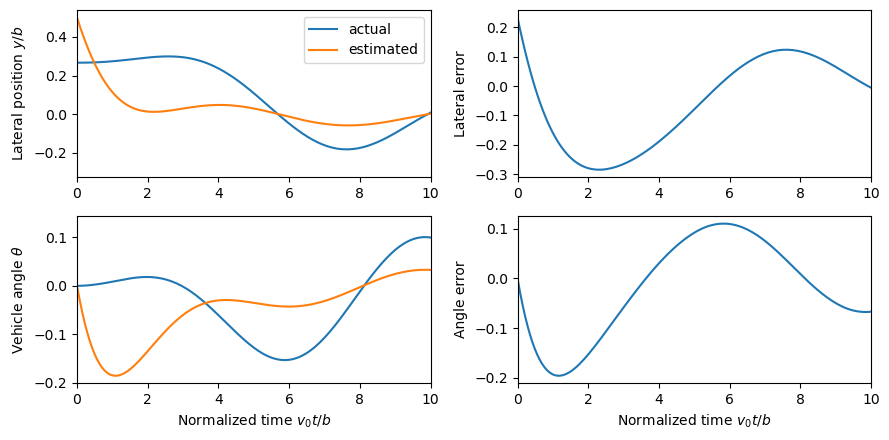

In [7]:
# Convert the curvy trajectory into normalized coordinates
x_ref = x_curvy[0] / wheelbase
y_ref = x_curvy[1] / wheelbase
theta_ref = x_curvy[2]
tau = v0 * T_curvy / b

# Simulate the estimator, with a small initial error in y position
t, y_est, x_est = ct.forced_response(est, tau, [delta_curvy, y_ref], [0.5, 0], return_x=True)

# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])

# Plot the actual and estimated states
ax = plt.subplot(2, 2, 1)
plt.plot(t, y_ref)
plt.plot(t, x_est[0])
ax.set(xlim=[0, 10])
plt.legend(['actual', 'estimated'])
plt.ylabel('Lateral position $y/b$')

ax = plt.subplot(2, 2, 2)
plt.plot(t, x_est[0] - y_ref)
ax.set(xlim=[0, 10])
plt.ylabel('Lateral error')

ax = plt.subplot(2, 2, 3)
plt.plot(t, theta_ref)
plt.plot(t, x_est[1])
ax.set(xlim=[0, 10])
plt.xlabel('Normalized time $v_0 t / b$')
plt.ylabel('Vehicle angle $\\theta$')

ax = plt.subplot(2, 2, 4)
plt.plot(t, x_est[1] - theta_ref)
ax.set(xlim=[0, 10])
plt.xlabel('Normalized time $v_0 t / b$')
plt.ylabel('Angle error')
plt.tight_layout()

K =  [[1.47   2.2344]]
kf =  0.489999999999918


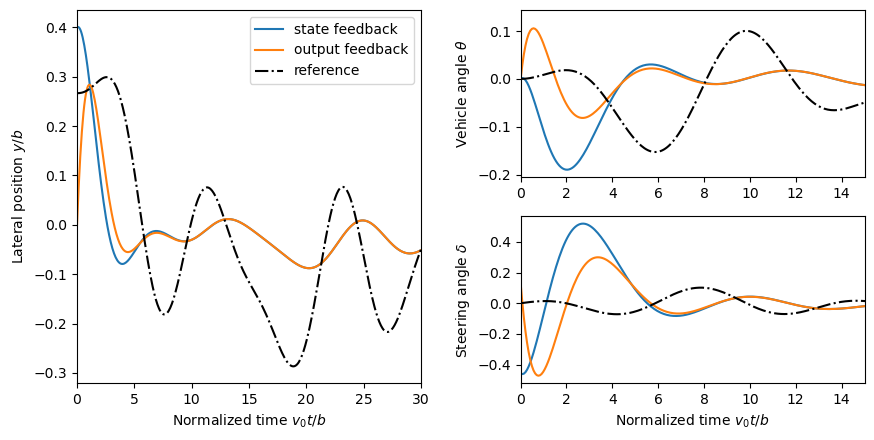

In [8]:
# Compute the feedback gains
# K, kf, clsys = normalized_place(1, 0.707)     # Gains from MATLAB
# K, kf, clsys = normalized_place(0.07, 0.707)  # Original gains
K, kf, clsys = normalized_place(0.7, 0.707)       # Final gains

# Print out the gains
print("K = ", K)
print("kf = ", kf)

# Construct an output-based controller for the system
clsys = ct.StateSpace(
    np.block([[A, -B@K], [L@C, A - B@K - L@C]]),
    np.block([[B], [B]]) * kf,
    np.block([[C, np.zeros(C.shape)], [np.zeros(C.shape), C]]),
    np.zeros((2,1)))

# Simulate the system
t, y, x = ct.forced_response(clsys, tau, y_ref, [0.4, 0, 0.0, 0], return_x=True)

# Calcaluate the input used to generate the control response
u_sfb = kf * y_ref - K @ x[0:2]
u_ofb = kf * y_ref - K @ x[2:4]

# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])

# Plot the actual and estimated states
ax = plt.subplot(1, 2, 1)
plt.plot(t, x[0])
plt.plot(t, x[2])
plt.plot(t, y_ref, 'k-.')
ax.set(xlim=[0, 30])
plt.legend(['state feedback', 'output feedback', 'reference'])
plt.xlabel('Normalized time $v_0 t / b$')
plt.ylabel('Lateral position $y/b$')

ax = plt.subplot(2, 2, 2)
plt.plot(t, x[1])
plt.plot(t, x[3])
plt.plot(t, theta_ref, 'k-.')
ax.set(xlim=[0, 15])
plt.ylabel('Vehicle angle $\\theta$')

ax = plt.subplot(2, 2, 4)
plt.plot(t, u_sfb[0])
plt.plot(t, u_ofb[0])
plt.plot(t, delta_curvy, 'k-.')
ax.set(xlim=[0, 15])
plt.xlabel('Normalized time $v_0 t / b$')
plt.ylabel('Steering angle $\\delta$')
plt.tight_layout()

In [9]:
import control.flatsys as fs

# Function to take states, inputs and return the flat flag
def vehicle_flat_forward(x, u, params={}):
    # Get the parameter values
    b = params.get('wheelbase', 3.)

    # Create a list of arrays to store the flat output and its derivatives
    zflag = [np.zeros(3), np.zeros(3)]

    # Flat output is the x, y position of the rear wheels
    zflag[0][0] = x[0]
    zflag[1][0] = x[1]

    # First derivatives of the flat output
    zflag[0][1] = u[0] * np.cos(x[2])  # dx/dt
    zflag[1][1] = u[0] * np.sin(x[2])  # dy/dt

    # First derivative of the angle
    thdot = (u[0]/b) * np.tan(u[1])

    # Second derivatives of the flat output (setting vdot = 0)
    zflag[0][2] = -u[0] * thdot * np.sin(x[2])
    zflag[1][2] =  u[0] * thdot * np.cos(x[2])

    return zflag

# Function to take the flat flag and return states, inputs
def vehicle_flat_reverse(zflag, params={}):
    # Get the parameter values
    b = params.get('wheelbase', 3.)

    # Create a vector to store the state and inputs
    x = np.zeros(3)
    u = np.zeros(2)

    # Given the flat variables, solve for the state
    x[0] = zflag[0][0]  # x position
    x[1] = zflag[1][0]  # y position
    x[2] = np.arctan2(zflag[1][1], zflag[0][1])  # tan(theta) = ydot/xdot

    # And next solve for the inputs
    u[0] = zflag[0][1] * np.cos(x[2]) + zflag[1][1] * np.sin(x[2])
    thdot_v = zflag[1][2] * np.cos(x[2]) - zflag[0][2] * np.sin(x[2])
    u[1] = np.arctan2(thdot_v, u[0]**2 / b)

    return x, u

vehicle_flat = fs.FlatSystem(vehicle_flat_forward, vehicle_flat_reverse, inputs=2, states=3)

In [10]:
# Utility function to plot lane change trajectory
def plot_vehicle_lanechange(traj):
    # Create the trajectory
    t = np.linspace(0, Tf, 100)
    x, u = traj.eval(t)

    # Configure matplotlib plots to be a bit bigger and optimize layout
    plt.figure(figsize=[9, 4.5])

    # Plot the trajectory in xy coordinate
    plt.subplot(1, 4, 2)
    plt.plot(x[1], x[0])
    plt.xlabel('y [m]')
    plt.ylabel('x [m]')

    # Add lane lines and scale the axis
    plt.plot([-4, -4], [0, x[0, -1]], 'k-', linewidth=1)
    plt.plot([0, 0], [0, x[0, -1]], 'k--', linewidth=1)
    plt.plot([4, 4], [0, x[0, -1]], 'k-', linewidth=1)
    plt.axis([-10, 10, -5, x[0, -1] + 5])

    # Time traces of the state and input
    plt.subplot(2, 4, 3)
    plt.plot(t, x[1])
    plt.ylabel('y [m]')

    plt.subplot(2, 4, 4)
    plt.plot(t, x[2])
    plt.ylabel('theta [rad]')

    plt.subplot(2, 4, 7)
    plt.plot(t, u[0])
    plt.xlabel('Time t [sec]')
    plt.ylabel('v [m/s]')
    # plt.axis([0, t[-1], u0[0] - 1, uf[0] + 1])

    plt.subplot(2, 4, 8)
    plt.plot(t, u[1]);
    plt.xlabel('Time t [sec]')
    plt.ylabel('$\delta$ [rad]')
    plt.tight_layout()

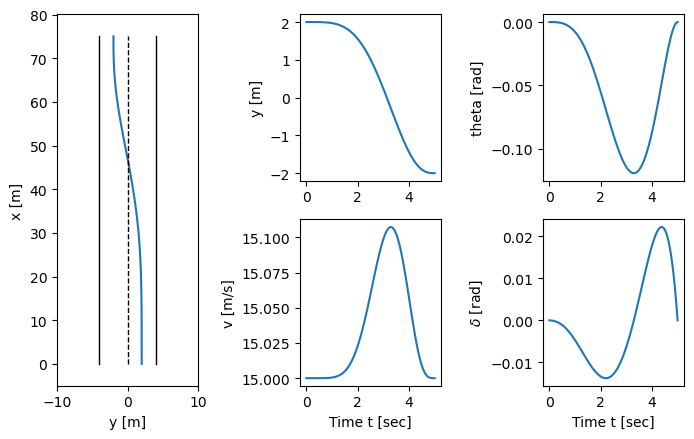

In [11]:
# Define the endpoints of the trajectory
x0 = [0., 2., 0.]; u0 = [15, 0.]
xf = [75, -2., 0.]; uf = [15, 0.]
Tf = xf[0] / uf[0]

# Define a set of basis functions to use for the trajectories
poly = fs.PolyFamily(8)

# Find a trajectory between the initial condition and the final condition
traj1 = fs.point_to_point(vehicle_flat, Tf, x0, u0, xf, uf, basis=poly)
plot_vehicle_lanechange(traj1)

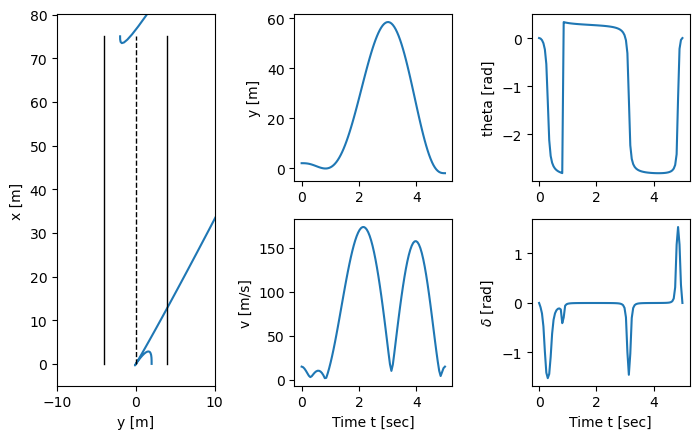

In [12]:
bezier = fs.BezierFamily(8)
traj2 = fs.point_to_point(vehicle_flat, Tf, x0, u0, xf, uf, basis=bezier)
plot_vehicle_lanechange(traj2)

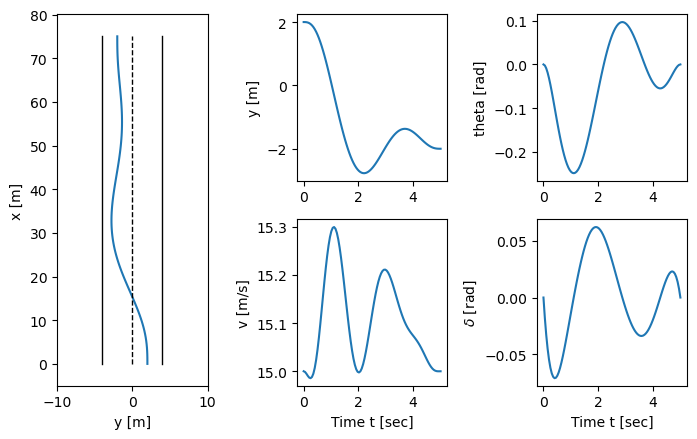

In [13]:
timepts = np.linspace(0, Tf, 12)
poly = fs.PolyFamily(8)
traj_cost = opt.quadratic_cost(
    vehicle_flat, np.diag([0, 0.1, 0]), np.diag([0.1, 10]), x0=xf, u0=uf)
constraints = [
     opt.input_range_constraint(vehicle_flat, [8, -0.1], [12, 0.1]) ]

traj3 = fs.point_to_point(
     vehicle_flat, timepts, x0, u0, xf, uf, cost=traj_cost, basis=poly
)
plot_vehicle_lanechange(traj3)

In [14]:
# Magnitude of the steering input (half maximum)
Msteer = vehicle_params['maxsteer'] / 2

# Create a linearized model of the system going forward at 2 m/s
forward_lateral = ct.linearize(lateral, [0, 0], [0], params={'velocity': 2})
forward_tf = ct.ss2tf(forward_lateral)[0, 0]
print("Forward TF = ", forward_tf)

# Create a linearized model of the system going in reverise at 1 m/s
reverse_lateral = ct.linearize(lateral, [0, 0], [0], params={'velocity': -2})
reverse_tf = ct.ss2tf(reverse_lateral)[0, 0]
print("Reverse TF = ", reverse_tf)

Forward TF =  <TransferFunction>: sys[20]$indexed
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


          s + 1.333
-----------------------------
s^2 + 7.828e-16 s - 1.848e-16

Reverse TF =  <TransferFunction>: sys[22]$indexed
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


         -s + 1.333
-----------------------------
s^2 - 7.828e-16 s - 1.848e-16



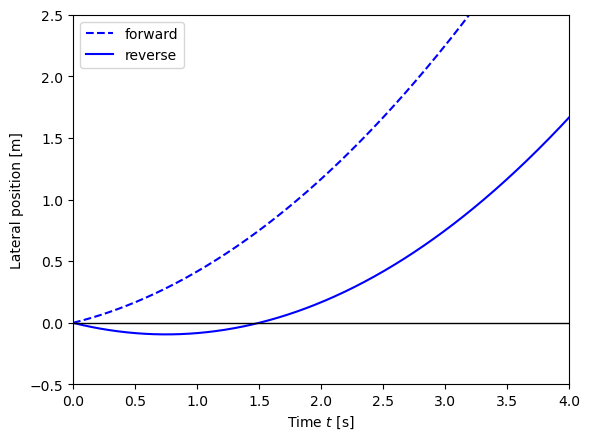

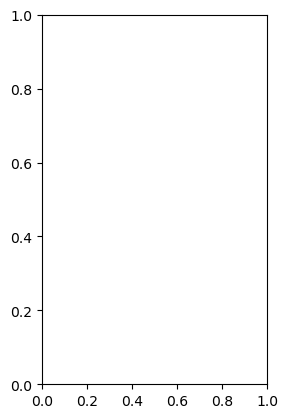

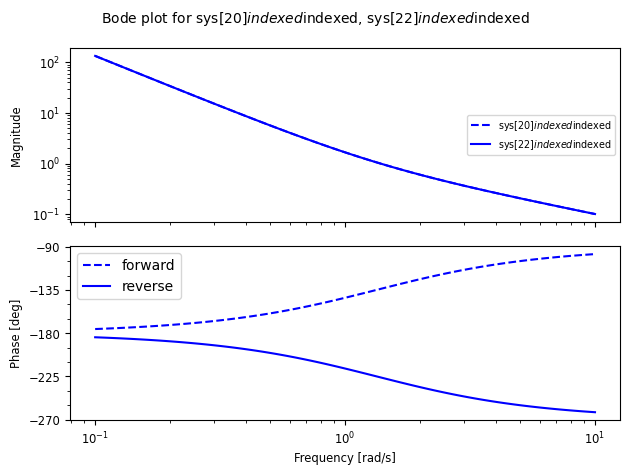

In [15]:
# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure()

# Forward motion
t, y = ct.step_response(forward_tf * Msteer, np.linspace(0, 4, 500))
plt.plot(t, y, 'b--')

# Reverse motion
t, y = ct.step_response(reverse_tf * Msteer, np.linspace(0, 4, 500))
plt.plot(t, y, 'b-')

# Add labels and reference lines
plt.axis([0, 4, -0.5, 2.5])
plt.legend(['forward', 'reverse'], loc='upper left')
plt.xlabel('Time $t$ [s]')
plt.ylabel('Lateral position [m]')
plt.plot([0, 4], [0, 0], 'k-', linewidth=1)

# Plot the Bode plots
plt.figure()
plt.subplot(1, 2, 2)
ct.bode_plot(forward_tf[0, 0], np.logspace(-1, 1, 100), color='b', linestyle='--')
ct.bode_plot(reverse_tf[0, 0], np.logspace(-1, 1, 100), color='b', linestyle='-')
plt.legend(('forward', 'reverse'));


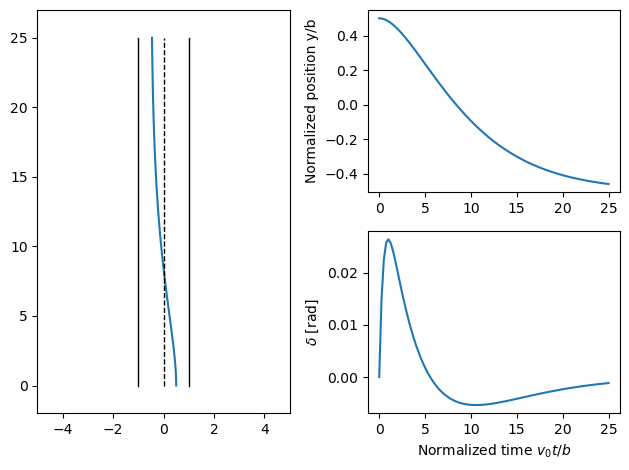

In [16]:
# Define the desired response of the system
a = 0.2
P = ct.ss2tf(lateral_normalized)
Fm = ct.TransferFunction([a**2], [1, 2*a, a**2])
Fr = Fm / P

# Compute the step response of the feedforward components
t, y_ffwd = ct.step_response(Fm, np.linspace(0, 25, 100))
t, delta_ffwd = ct.step_response(Fr, np.linspace(0, 25, 100))

# Scale and shift to correspond to lane change (-2 to +2)
y_ffwd = 0.5 - 1 * y_ffwd
delta_ffwd *= 1

# Overhead view
plt.subplot(1, 2, 1)
plt.plot(y_ffwd, t)
plt.plot(-1*np.ones(t.shape), t, 'k-', linewidth=1)
plt.plot(0*np.ones(t.shape), t, 'k--', linewidth=1)
plt.plot(1*np.ones(t.shape), t, 'k-', linewidth=1)
plt.axis([-5, 5, -2, 27])

# Plot the response
plt.subplot(2, 2, 2)
plt.plot(t, y_ffwd)
# plt.axis([0, 10, -5, 5])
plt.ylabel('Normalized position y/b')

plt.subplot(2, 2, 4)
plt.plot(t, delta_ffwd)
# plt.axis([0, 10, -1, 1])
plt.ylabel('$\\delta$ [rad]')
plt.xlabel('Normalized time $v_0 t / b$');

plt.tight_layout()

K =  [ 300.   -107.58]
L =  [  9.42666667 133.33333333]
C(s) =  <TransferFunction>: sys[41]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


-1.152e+04 s + 4e+04
--------------------
s^2 + 42.42 s + 6658



C:\Users\AlitheiaDeus\anaconda3\envs\sit\Lib\site-packages\control\freqplot.py:1440: UserWarning: number of encirclements was a non-integer value; this can happen is contour is not closed, possibly based on a frequency range that does not include zero.
  warnings.warn(
C:\Users\AlitheiaDeus\anaconda3\envs\sit\Lib\site-packages\control\freqplot.py:1737: UserWarning: number of encirclements does not match Nyquist criterion; check frequency range and indent radius/direction
  nyquist_responses = nyquist_response(


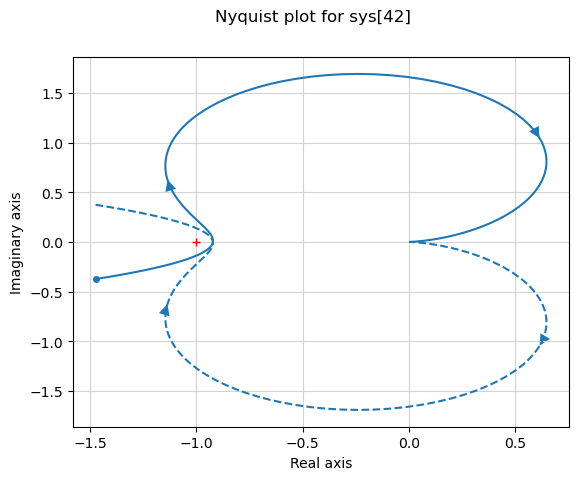

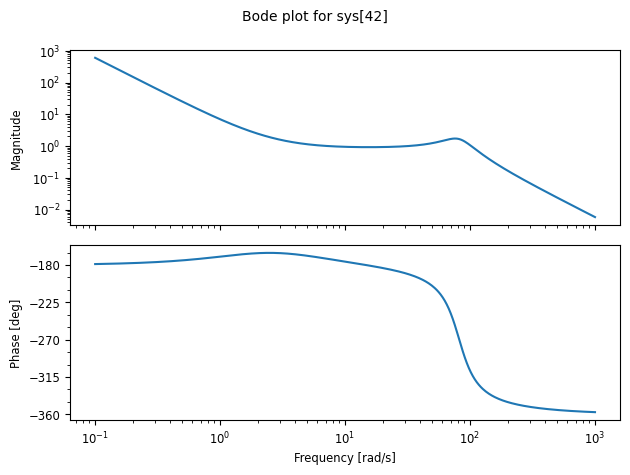

In [17]:
# Compute the feedback gain using eigenvalue placement
wc = 10
zc = 0.707
eigs = np.roots([1, 2*zc*wc, wc**2])
K = ct.place(A, B, eigs)
kr = np.real(1/clsys(0))
print("K = ", np.squeeze(K))

# Compute the estimator gain using eigenvalue placement
wo = 20
zo = 0.707
eigs = np.roots([1, 2*zo*wo, wo**2])
L = np.transpose(
    ct.place(np.transpose(A), np.transpose(C), eigs))
print("L = ", np.squeeze(L))

# Construct an output-based controller for the system
C1 = ct.ss2tf(ct.StateSpace(A - B@K - L@C, L, K, 0))
print("C(s) = ", C1)

# Compute the loop transfer function and plot Nyquist, Bode
L1 = P * C1
plt.figure(); ct.nyquist_plot(L1, np.logspace(0.5, 3, 500))
plt.figure(); ct.bode_plot(L1, np.logspace(-1, 3, 500));

In [18]:
# Modified control law
wc = 10
zc = 2.6
eigs = np.roots([1, 2*zc*wc, wc**2])
K = ct.place(A, B, eigs)
kr = np.real(1/clsys(0))
print("K = ", np.squeeze(K))

# Construct an output-based controller for the system
C2 = ct.ss2tf(ct.StateSpace(A - B@K - L@C, L, K, 0))
print("C(s) = ", C2)

K =  [300.   6.]
C(s) =  <TransferFunction>: sys[49]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


   3628 s + 4e+04
---------------------
s^2 + 80.28 s + 156.6



array([[list([<matplotlib.lines.Line2D object at 0x0000011C61D44690>]),
        list([<matplotlib.lines.Line2D object at 0x0000011C63CB1E50>])],
       [list([<matplotlib.lines.Line2D object at 0x0000011C63F32FD0>]),
        list([<matplotlib.lines.Line2D object at 0x0000011C63D36650>])]],
      dtype=object)

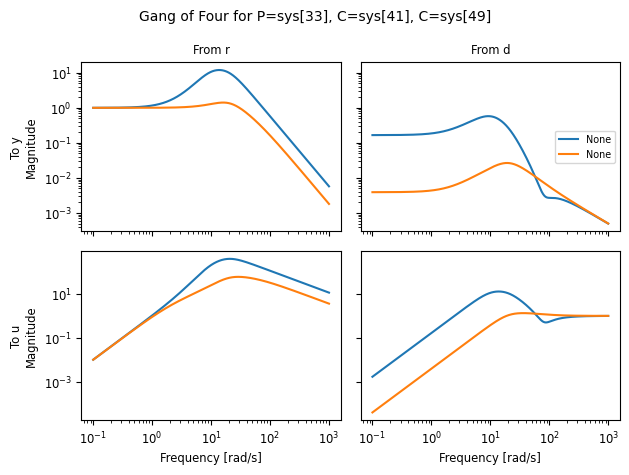

In [19]:
# Plot the gang of four for the two designs
ct.gangof4(P, C1, np.logspace(-1, 3, 100))
ct.gangof4(P, C2, np.logspace(-1, 3, 100))